In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)

### Importing text datasets

In [3]:
text_data_path_1 = 'text_data_1.csv'
text_data_path_2 = 'text_data_2.data'

In [4]:
df_1 = pd.read_csv(text_data_path_1)
print('number of dataset: {}'.format(df_1.shape[0]))
print('emotion types: {} types\n{}'.format(df_1['sentiment'].nunique(),df_1['sentiment'].unique()))
df_1.head()

number of dataset: 40000
emotion types: 13 types
['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [5]:
df_2 = pd.read_csv(text_data_path_2)
print('number of dataset: {}'.format(df_2.shape[0]))
print('emotion types: {} types\n{}'.format(df_2['emotions'].nunique(),df_2['emotions'].unique()))
df_2.head()

number of dataset: 416809
emotion types: 6 types
['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


,Unnamed: 0,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


### Text data pre-processing

In [6]:
df_1_col_tokeep = ['sentiment','content']
df_1_sentiment_filter = ['worry','sadness','love','surprise','fun','hate','anger']
df_1 = df_1[df_1_col_tokeep]
df_1 = df_1[df_1['sentiment'].isin(df_1_sentiment_filter)]
df_1 = df_1.rename(columns = {"sentiment": "emotions","content":"text"}) 

emotion_rename = {'worry':'fear','fun':'joy','hate':'anger'}
df_1 = df_1.replace({'emotions':emotion_rename})

In [7]:
def text_preprocessing(text):
    new_text = ' '.join(x for x in text.strip().lower().split() if not x.startswith('@'))
    new_text = ' '.join('website' if x.startswith('http://') else x for x in new_text.split())
    
    return new_text         

In [8]:
df_1['text'] = df_1['text'].apply(text_preprocessing)
df_2['text'] = df_2['text'].apply(text_preprocessing)
df_2 = df_2[['emotions','text']]

In [54]:
df = pd.concat([df_1,df_2])
df = df.reset_index(drop=True)

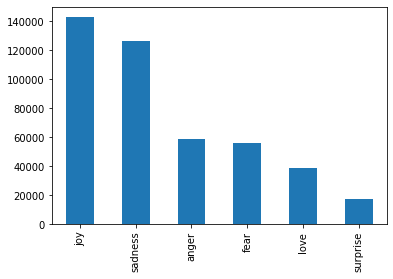

In [55]:
df['emotions'].value_counts().plot.bar()

## downsampling 

In [56]:
df_joy_temp = df[df['emotions']=='joy']
df_sadness_temp = df[df['emotions']=='sadness']
df_anger_temp = df[df['emotions']=='anger']
df_fear_temp = df[df['emotions']=='fear']
df_love_temp = df[df['emotions']=='love']
from sklearn.utils import shuffle

df_joy_temp = shuffle(df_joy_temp)#.sample(frac=1).reset_index(drop=True)
df_sadness_temp = shuffle(df_sadness_temp)#.sample(frac=1).reset_index(drop=True)
df_anger_temp = shuffle(df_anger_temp)#.sample(frac=1).reset_index(drop=True)
df_fear_temp = shuffle(df_fear_temp)#.sample(frac=1).reset_index(drop=True)
df_love_temp = shuffle(df_love_temp)#.sample(frac=1).reset_index(drop=True)

In [58]:
df_joy_temp = df_joy_temp[1:int(np.ceil(len(df_joy_temp)/7))]
df_sadness_temp = df_sadness_temp[1:int(np.ceil(len(df_sadness_temp)/6))]
df_anger_temp = df_anger_temp[1:int(np.ceil(len(df_anger_temp)/3))]
df_fear_temp = df_fear_temp[1:int(np.ceil(len(df_fear_temp)/3))] 
df_love_temp = df_love_temp[1:int(np.ceil(len(df_love_temp)/2))] 

In [59]:
df_rest_temp = df[df['emotions']=='surprise']

In [60]:
df = pd.concat([df_joy_temp,df_sadness_temp,df_anger_temp,df_fear_temp,df_love_temp,df_rest_temp])

In [61]:
df = shuffle(df)#.sample(frac=1).reset_index(drop=True)

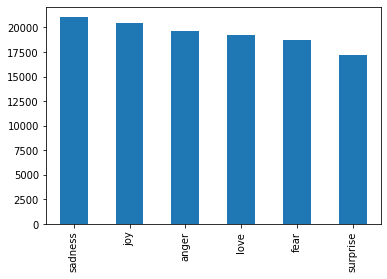

In [62]:
df['emotions'].value_counts().plot.bar()

In [64]:
len(df)

116126

In [66]:
df = df.reset_index()

In [67]:
df.head()

,index,emotions,text
0,9416,anger,good 1km visible shot of td one shows total de...
1,223011,surprise,i dont even know how i feel just weird
2,80299,surprise,i couldn t let this one go of course but i cou...
3,138116,joy,i am delighted with my result and feel hopeful...
4,218052,love,i feel i m very loyal to


In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
  
# Creating train and dev dataframes according to BERT
df_bert = pd.DataFrame({'user_id':df['index'],
            'label':le.fit_transform(df['emotions']),
            'alpha':['a']*df.shape[0],
            'text':df['text'].replace(r'\n',' ',regex=True)})
 
df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.01)
 
# # Creating test dataframe according to BERT
# df_test = pd.read_csv("data/test.csv")
# df_bert_test = pd.DataFrame({'User_ID':df_test['User_ID'],
#                  'text':df_test['Description'].replace(r'\n',' ',regex=True)})


In [ ]:
# Saving dataframes to .tsv format as required by BERT
df_bert_train.to_csv('data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev.to_csv('data/dev.tsv', sep='\t', index=False, header=False)
# df_bert_test.to_csv('data/test.tsv', sep='\t', index=False, header=True)

In [387]:
df.head()
X = df['text'].tolist()
y = df['emotions'].tolist()
emotion_type = np.unique(y)

In [374]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [375]:
X = np.asarray(X)
y = np.asarray(pd.get_dummies(y),dtype=np.int8)

In [380]:
X_train,X_valid_test,y_train,y_valid_test = train_test_split(X,y,test_size=0.05,random_state=0,stratify=y)
X_valid,X_test,y_valid,y_test = train_test_split(X_valid_test,y_valid_test,test_size=0.5,random_state=0,stratify=y_valid_test)
print('X_train shape: {}'.format(len(X_train)))
print('y_train shape: {}'.format(len(y_train)))
print('X_valid shape: {}'.format(len(X_valid)))
print('y_valid shape: {}'.format(len(y_valid)))
print('X_test shape: {}'.format(len(X_test)))
print('y_test shape: {}'.format(len(y_test)))

X_train shape: 417687
y_train shape: 417687
X_valid shape: 10992
y_valid shape: 10992
X_test shape: 10992
y_test shape: 10992


In [381]:
from tensorflow.keras.layers import Input,Lambda,Dense
from tensorflow.keras.models import Model
import keras.backend as K

In [382]:
def USE(x): #universal sentence encoding
    return embed(tf.squeeze(tf.cast(x, tf.string)))

In [383]:
input_text = Input(shape=(1,), dtype=tf.string)
embedding = Lambda(USE,output_shape=(512,))(input_text)
dense = Dense(256, activation='relu')(embedding)
pred = Dense(df['emotions'].nunique(),activation='softmax')(dense)
model = Model(inputs=[input_text],outputs=pred)
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [384]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 132,870
Trainable params: 132,870
Non-trainable params: 0
_________________________________________________________________


In [385]:
type(y_train)

numpy.ndarray

In [386]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    history = model.fit(X_train,y_train,
              validation_data=(X_valid,y_valid),
              epochs=1,
              batch_size=64)
#     model.save_weights('./model.h5')

Train on 417687 samples, validate on 10992 samples
Epoch 1/1
  8064/417687 [..............................] - ETA: 1:37:02 - loss: 1.3144 - acc: 0.5246

KeyboardInterrupt: 